# Section 4.1.5. Diffusion Models - DDPM

## 1. Training Stage

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

np.random.seed(0)
torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
hts_df = pd.read_csv('hts_example.csv', index_col=None)
    
num_categories = {}
for column in hts_df.columns:
    num_unique = hts_df[column].nunique()
    num_categories[column] = num_unique
    print(f"Column '{column}' has {num_unique} unique categories.")

Column 'start_type' has 5 unique categories.
Column 'act_num' has 9 unique categories.
Column 'mode_num' has 9 unique categories.
Column 'end_type' has 5 unique categories.


In [3]:
def dequantize_data(data):
    data_continuous = data.copy().astype(float)
    for column in data_continuous.columns:
        data_continuous[column] += np.random.uniform(0, 1, size=data_continuous.shape[0])
    return data_continuous

data_continuous = dequantize_data(hts_df)
data_tensor = torch.tensor(data_continuous.values, dtype=torch.float32).to(device)

In [4]:
# Diffusion hyperparameters
T = 1000  # Number of diffusion steps
betas = torch.linspace(1e-4, 0.02, T).to(device)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0]).to(device), alphas_cumprod[:-1]])

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod).to(device)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod).to(device)

# Time Embedding Function
def get_timestep_embedding(timesteps, embedding_dim):
    """
    Generates sinusoidal timestep embeddings.
    """
    half_dim = embedding_dim // 2
    emb = np.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb).float()
    emb = timesteps.float().unsqueeze(1) * emb.unsqueeze(0)
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    return emb  # Shape: (batch_size, embedding_dim)

class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, time_embedding_dim=128):
        super(DiffusionModel, self).__init__()
        self.time_embedding_dim = time_embedding_dim
        self.net = nn.Sequential(
            nn.Linear(input_dim + time_embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x, t):
        """
        x: Noisy input data, shape (batch_size, input_dim)
        t: Time steps, shape (batch_size,)
        """
        t_emb = get_timestep_embedding(t, self.time_embedding_dim)  # Shape: (batch_size, time_embedding_dim)
        x_t = torch.cat([x, t_emb], dim=1)  # Shape: (batch_size, input_dim + time_embedding_dim)
        return self.net(x_t)  # Predicts the noise

# Forward Diffusion (Adding Noise)
def forward_diffusion_sample(x0, t):
    """
    Takes an original sample x0 and a timestep t, returns the noisy sample x_t and the noise added.
    """
    noise = torch.randn_like(x0).to(device)
    sqrt_alpha_prod = sqrt_alphas_cumprod[t].view(-1, 1)  # Shape: (batch_size, 1)
    sqrt_one_minus_alpha_prod = sqrt_one_minus_alphas_cumprod[t].view(-1, 1)  # Shape: (batch_size, 1)
    x_t = sqrt_alpha_prod * x0 + sqrt_one_minus_alpha_prod * noise  # Shape: (batch_size, input_dim)
    return x_t, noise


In [5]:
hidden_dim = 256
time_embedding_dim = 128

input_dim = data_tensor.shape[1]
diffusion_model = DiffusionModel(input_dim=input_dim, hidden_dim=hidden_dim, time_embedding_dim=time_embedding_dim).to(device)

In [6]:
learning_rate = 1e-3
batch_size = 512
epochs = 20    

optimizer = optim.Adam(diffusion_model.parameters(), lr=learning_rate)
dataset = torch.utils.data.TensorDataset(data_tensor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

diffusion_model.train()
for epoch in range(1, epochs + 1):
    epoch_loss = 0.0
    for batch in dataloader:
        x0 = batch[0].to(device)  # Original data
        batch_size = x0.size(0)

        # Sample a random time step for each data point
        t = torch.randint(0, T, (batch_size,), device=device).long()

        # Get the noisy sample and the true noise
        x_t, noise = forward_diffusion_sample(x0, t)

        # Predict the noise using the model
        noise_pred = diffusion_model(x_t, t)

        # Compute the loss (Mean Squared Error between predicted and true noise)
        loss = nn.functional.mse_loss(noise_pred, noise)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    # Logging
    if epoch % 2 == 0 or epoch == 1:
        avg_loss = epoch_loss / len(dataloader)
        print(f'Epoch [{epoch}/{epochs}], Loss: {avg_loss:.6f}')

Epoch [1/20], Loss: 0.323713
Epoch [2/20], Loss: 0.272659
Epoch [4/20], Loss: 0.260831
Epoch [6/20], Loss: 0.253323
Epoch [8/20], Loss: 0.251309
Epoch [10/20], Loss: 0.251704
Epoch [12/20], Loss: 0.247791
Epoch [14/20], Loss: 0.249420
Epoch [16/20], Loss: 0.245636
Epoch [18/20], Loss: 0.246963
Epoch [20/20], Loss: 0.247193


## 2. Testing Stage

In [7]:
columns = ['start_type', 'act_num', 'mode_num', 'end_type']
num_samples=3000

diffusion_model.eval()

with torch.no_grad():
    # Initialize x_T with random noise
    x = torch.randn(num_samples, len(columns)).to(device)

    # Iterate from T-1 to 0
    for t in reversed(range(T)):
        t_tensor = torch.full((num_samples,), t, device=device, dtype=torch.long)  # Shape: (num_samples,)
        # Predict the noise
        noise_pred = diffusion_model(x, t_tensor)  # Shape: (num_samples, input_dim)

        # Compute coefficients
        sqrt_alpha_t = sqrt_alphas_cumprod[t].view(1, 1).to(device)  # Shape: (1, 1)
        sqrt_one_minus_alpha_t = sqrt_one_minus_alphas_cumprod[t].view(1, 1).to(device)  # Shape: (1, 1)
        beta_t = betas[t].view(1, 1).to(device)  # Shape: (1, 1)

        if t > 0:
            noise = torch.randn_like(x).to(device)
        else:
            noise = torch.zeros_like(x).to(device)  # No noise at t=0

        # Update x_t
        x = (x - beta_t * noise_pred) / torch.sqrt(alphas[t]) + torch.sqrt(beta_t) * noise

        # Numerical stability: clamp values to prevent extreme values
        x = torch.clamp(x, -10, 10)

# Map continuous samples back to categorical
generated_categories = pd.DataFrame(x.cpu().numpy(), columns=columns)
for column in columns:
    max_cat = num_categories[column] - 1
    # Apply floor and clamp to the valid range of categories
    generated_categories[column] = np.floor(generated_categories[column]).astype(int)
    generated_categories[column] = np.clip(generated_categories[column], 0, max_cat)

<ipython-input-12-b0187e9f1e47>:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f'{x:.2f}' for x in ax.get_yticks()], fontsize=15)


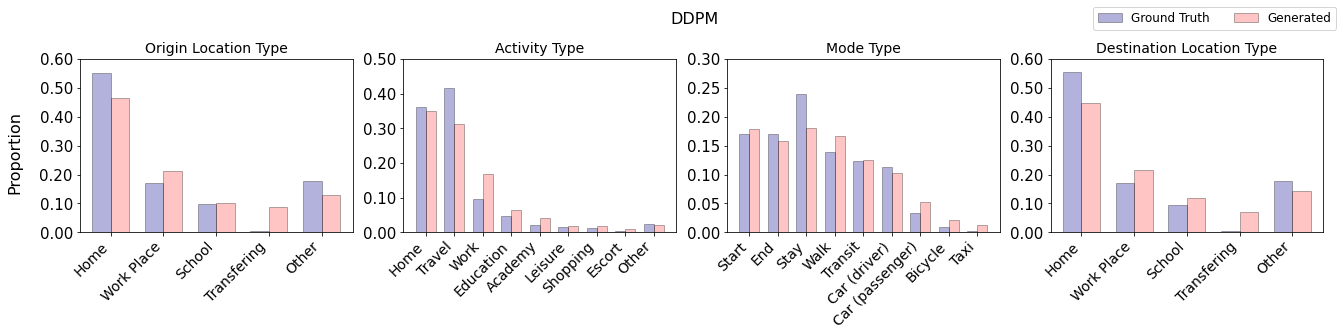

In [12]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] + plt.rcParams['font.sans-serif']

fig, axs = plt.subplots(1, 4, figsize=(18, 3))

formatter = FormatStrFormatter('%.2f')

fig.tight_layout(h_pad=1, w_pad=2)

ylim_list = [0.60, 0.5, 0.3, 0.6]
sub_title_list = ['Origin Location Type', 'Activity Type', 'Mode Type', 'Destination Location Type']
bar_width = 0.35
offset = bar_width / 2

xtick_labels_list = [
    ['Home', 'Work Place', 'School', 'Transfering', 'Other'],  # Start Location Type
    ['Home', 'Travel', 'Work', 'Education', 'Academy', 'Leisure', 'Shopping', 'Escort', 'Other'],  # Activity Type
    ['Start', 'End', 'Stay', 'Walk', 'Transit', 'Car (driver)', 'Car (passenger)', 'Bicycle', 'Taxi'],  # Mode Type
    ['Home', 'Work Place', 'School', 'Transfering', 'Other']  # End Location Type
]

for column, ylim, sub_title, xtick_labels, ax in zip(columns, ylim_list, sub_title_list, xtick_labels_list, axs.flatten()):
    
    # Ground truth
    unique_hts, counts_hts = np.unique(hts_df[column], return_counts=True)
    ax.set_ylim([0, ylim])
    positions_hts = np.arange(len(unique_hts))
    ax.bar(positions_hts - offset, counts_hts / counts_hts.sum(), 
           width=bar_width, color='#00008F', edgecolor='black', alpha=0.3, label='Ground Truth')
    
    # Generated data
    unique_gen, counts_gen = np.unique(generated_categories[column], return_counts=True)
    positions_gen = np.arange(len(unique_gen))
    ax.bar(positions_gen + offset, counts_gen / counts_gen.sum(), 
           width=bar_width, color='#FF4040', edgecolor='black', alpha=0.3, label='Generated')
    
    ax.set_xticks([int(x) for x in unique_hts])
    ax.set_xticklabels(xtick_labels, fontsize=14, rotation=45, ha='right')
    
    ax.yaxis.set_major_formatter(formatter)
    ax.set_yticklabels([f'{x:.2f}' for x in ax.get_yticks()], fontsize=15)

    ax.set_title(sub_title, fontsize=14)

fig.suptitle('DDPM', fontsize=16, y=1.15)
fig.text(-0.03, 0.5, 'Proportion', va='center', rotation='vertical', fontsize=16)

fig.legend(['Ground Truth', 'Generated'], loc='upper right', ncol=2, fontsize=12, 
           bbox_to_anchor=(1, 1.2), bbox_transform=fig.transFigure)

plt.savefig(f'ddpm_discrete.png', bbox_inches='tight', dpi=400)
plt.show()
plt.close()